In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer  #for other skills
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [60]:
####### load data #########################
all_data = pd.read_csv("C:/Users/Shruti/Downloads/foster-app-master/foster-app-master/sample-data/mavoix_ml_sample_dataset.csv", encoding = 'cp437' )


In [3]:
#replace empty skills box
def replace_empty_skills(df):    #pass 'Other skills' col
    ret_df= df.fillna('no other skill')
    return ret_df

In [4]:
### Performances N/A to 0
def performance_fillna(df):   #pass dataframe, return dataframe
    df['Performance_PG'] = df['Performance_PG'].fillna(0)
    df['Performance_UG']= df['Performance_UG'].fillna(0)
    df['Performance_12'] = df['Performance_12'].fillna(0)
    df['Performance_10'] = df['Performance_10'].fillna(0)
    return df

In [5]:
### Performances pg - standardize values ###

def pg_ug_standardize(df): #send only one column-pg/ug performance
    scores_pg =[]
    for x in df:
        if isinstance(x, str):
            scores_pg.append(x.split("/"))
        else:
            scores_pg.append([0, 0])

    percent_pg =[]
    for i in range(0, len(scores_pg)):
        if scores_pg[i][1] == '10':
            calc = float(scores_pg[i][0]) * 9.5 
            percent_pg.append(calc)
        elif scores_pg[i][1] == '4':
            calc = (float(scores_pg[i][0])/4 ) * 100 
            percent_pg.append(calc)
        elif scores_pg[i][1] == '7':
            calc = (float(scores_pg[i][0])/7 ) * 100 
            percent_pg.append(calc)
        elif scores_pg[i][1] == '100':
            percent_pg.append(scores_pg[i][0])
        else:
            percent_pg.append(int(0))
          
    df= [x for x in percent_pg]
    return df #list



In [6]:
### Performances 12 - standardize values ###
def standardize_10_12(df):    #send only one column- 10/12 performance
    scores_12 =[]
    for x in df:
        if isinstance(x, str):
            scores_12.append(x.split("/"))
        else:
            scores_12.append([0, 0])

    percent_12 =[]
    for i in range(0, len(scores_12)):
        if float(scores_12[i][0]) > 10 :  #is in percentage
            percent_12.append(scores_12[i][0])
        elif float(scores_12[i][0]) <= 4 :  #4 point cgpa
            calc = (float(scores_12[i][0])/4 ) * 100 
            percent_12.append(calc)
        elif float(scores_12[i][0]) == 0:
            percent_12.append(int(0))
        else:                               #10 point cgpa
            calc = float(scores_12[i][0]) * 9.5 
            percent_12.append(calc)
    
    df= [x for x in percent_12]
    return df #list


In [7]:
######## Create dummy variables ############
def dummy_stream_degree(df):    #pass stream/degree column
    dumm = pd.get_dummies(df)
    return dumm

#all_data = all_data.merge(dumm, left_index=True, right_index=True)

In [9]:
#tfidf for skill
def create_tfidf(df):       #pass train 'other skills' col
    tf_vect = TfidfVectorizer()
    tf_vect.fit(df)
    sk = tf_vect.get_feature_names() #new features
    return tf_vect

def tfidf_transform(tfidf_vect, df):           #pass train/test 'Other skills' col
    skill_matrix = tfidf_vect.transform(df)
    return skill_matrix

In [11]:
# combine tfidf skills with main data
def combine_skill_data(new_data, skill_matrix, tfidf_vect):    
    tfidf_data = pd.DataFrame(skill_matrix.toarray(), columns = tfidf_vect.get_feature_names())
    for col in tfidf_data.columns:
        new_data[col] = tfidf_data[col].values
    return new_data

In [61]:
############### call functions-  #######################
all_data['Other skills'] = replace_empty_skills(all_data['Other skills'])
all_data = performance_fillna(all_data)

#standardize marks
df = pg_ug_standardize(all_data['Performance_PG'])
all_data['Performance_PG']= df


df = pg_ug_standardize(all_data['Performance_UG'])
all_data['Performance_UG']= df

df = standardize_10_12(all_data['Performance_12'])
all_data['Performance_12']= df

df = standardize_10_12(all_data['Performance_10'])
all_data['Performance_10']= df


#create dummy variables
#stream column
dum_str = dummy_stream_degree(all_data['Stream'])
all_data = all_data.merge(dum_str, left_index=True, right_index=True)

#degree column
dum_deg = dummy_stream_degree(all_data['Degree'])
all_data = all_data.merge(dum_deg, left_index=True, right_index=True)

#split data
test = all_data[0: int(all_data.shape[0]/4)]
train = all_data[int(all_data.shape[0]/4): ]
    
#no split
tfidf_vect = create_tfidf(all_data['Other skills'])
tfidf = tfidf_transform(tfidf_vect, all_data['Other skills'] )  #no splitting

dropped_df = all_data.drop(['Current City','Unnamed: 10', 'Other skills', 'Stream', 'Degree' ], axis=1)
df_full = combine_skill_data(dropped_df, tfidf, tfidf_vect)

###############################################################################################

In [48]:
#pca to visualize the labeled data and reduce features
pca = PCA()
pca_val = pd.DataFrame(pca.fit_transform(df_full.iloc[:, 1:-1])) #transformed features, not include Application ID

pca_feat = pd.DataFrame(pca.components_)  #eigenvectors
X = pd.DataFrame(pca_val.iloc[:, 0:2]) #training features from top 2 pc's - FOR easy visualization

In [77]:
########### CLustering using PC features ##############
cls = KMeans(n_clusters=4, max_iter=200)
cls.fit(X)    #not sending application ID
df_full['labels'] = cls.labels_  #join col to record


C:\Users\Shruti\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


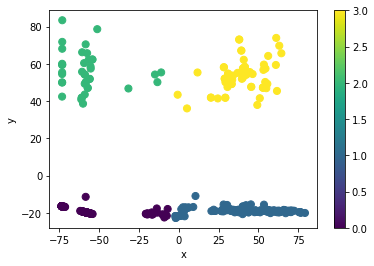

In [78]:
#visualize the clusters
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X[0],X[1],c=df_full['labels'],s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

fig.show()

In [80]:
# Choose candidates from cluster label=0 as they have higher PCA values- hence more info in the dataset
#that is- more skills
df_full['labels'][df_full['labels']== 3]= 'selected'
df_full['labels'][df_full['labels']== 0] = 'not selected'
df_full['labels'][df_full['labels']== 1] = 'not selected'
df_full['labels'][df_full['labels']== 2] = 'not selected'

C:\Users\Shruti\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
selected_app = df_full[df_full['labels']== 'selected']['Application_ID']

In [82]:
application = pd.read_csv("C:/Users/Shruti/Downloads/foster-app-master/foster-app-master/sample-data/mavoix_ml_sample_dataset.csv", encoding = 'cp437' )


In [87]:
########### THESE ARE THE PREFERRED CANDIDATES ####################

application[application['Application_ID'].isin(selected_app)]

,Application_ID,Current City,Python (out of 3),R Programming (out of 3),Deep Learning (out of 3),PHP (out of 3),MySQL (out of 3),HTML (out of 3),CSS (out of 3),JavaScript (out of 3),...,Node.js (out of 3),ReactJS (out of 3),Other skills,Degree,Stream,Current Year Of Graduation,Performance_PG,Performance_UG,Performance_12,Performance_10
2,ML0003,Bangalore,3,0,1,2,2,2,0,2,...,0,0,"Algorithms, Data Structures, Python, C Program...",Master of Science (M.Sc),Computer Science,2018,7.91/10,70.00/100,64.83/64.83,77.60/77.60
8,ML0009,Bangalore,3,0,0,0,0,2,2,0,...,0,0,"English Proficiency (Spoken), English Proficie...",Post Graduate Programme (PGP),Data Science,2020,8.00/10,7.00/10,70.00/70.00,93.00/93.00
19,ML0020,Chennai,2,0,0,2,2,2,2,2,...,0,1,"BIG DATA ANALYTICS, Data Analytics, Database M...",Post Graduate Diploma,Data Science,2019,5.60/10,65.00/100,NaN,89.00/89.00
21,ML0022,Bangalore,1,1,0,0,0,0,0,0,...,0,0,"Python, R Programming",Master of Science (M.Sc),Statistics,2019,3.76/4,3.56/4,80.50/80.50,85.85/85.85
25,ML0026,Hyderabad,2,0,0,0,0,2,0,0,...,0,0,"C Programming, Java, MySQL, PHP, Python",Master of Computer Applications (MCA),Computer Application,2018,8.35/10,75.00/100,84.30/84.30,76.00/76.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,ML0375,Bangalore,2,0,2,0,2,2,2,1,...,0,0,"Arduino, Bootstrap, CSS, HTML, MySQL, Python, ...",B.Tech (Hons.),Computer Science,2019,7.60/10,7.60/10,64.00/64.00,6.66/6.66
377,ML0378,Guwahati,0,0,0,2,0,2,2,2,...,0,0,"Adobe Photoshop, C Programming, C++ Programmin...",Master of Computer Applications (MCA),NaN,2020,6.35/10,53.97/100,55.40/55.40,6.60/6.60
381,ML0382,Bangalore,2,0,0,3,0,3,2,3,...,0,0,"Algorithms, C Programming, Data Structures, Da...",Master of Computer Applications (MCA),Computer Application,2019,71.60/100,80.60/100,53.80/53.80,68.00/68.00
384,ML0385,Bangalore,1,1,0,0,0,0,0,0,...,0,0,"C Programming, Java, Python",Master of Computer Applications (MCA),Computer Science,2020,6.50/7,73.00/100,75.00/75.00,63.50/63.50
